In [ ]:
# BO experiment name: feed_integrity_control_panel_vm_tuning_quickbo
# PE experiment name: pe_pilot_feed_integrity_control_panel_vm_tuning_quickbo_no_ci

In [54]:
%load_ext autoreload
%autoreload 2

import copy
import time
import warnings  # noqa

from collections import defaultdict
from typing import Dict, Optional, Tuple, Type

import matplotlib.pylab as plt

# import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from ae.pca.models import compute_principal_axes

# import my own code, which is under ae/pca/
from ae.pca.simulation import generate_principal_axes, PCATestProblem
from ae.pca.transforms import (
    generate_random_projection,
    InputCenter,
    LinearProjectionInputTransform,
    LinearProjectionOutcomeTransform,
    PCAInputTransform,
    PCAOutcomeTransform,
    SubsetOutcomeTransform,
)

from ax.core.data import Data
from ax.core.experiment import Experiment
from ax.core.metric import Metric
from ax.core.objective import MultiObjective, Objective, ScalarizedObjective
from ax.core.observation import ObservationFeatures
from ax.core.optimization_config import (
    MultiObjectiveOptimizationConfig,
    OptimizationConfig,
)
from ax.core.parameter import ParameterType, RangeParameter
from ax.core.runner import Runner
from ax.core.search_space import SearchSpace
from ax.fb.metrics.deltoid3 import Deltoid3Metric
from ax.fb.models.torch.botorch_modular.preference import PreferenceModelAcquisition
from ax.fb.plot.notebook import render
from ax.fb.service.ax_batch_client import AxBatchClient
from ax.fb.storage.registries.pts_registry_bundle import PTS_REGISTRY_BUNDLE
from ax.fb.storage.sqa_store.load import load_experiment
from ax.fb.storage.sqa_store.save import save_experiment
from ax.modelbridge.cross_validation import cross_validate
from ax.modelbridge.modelbridge_utils import extract_search_space_digest
from ax.modelbridge.pairwise import PairwiseModelBridge
from ax.modelbridge.registry import Cont_X_trans, Models, ST_MTGP_trans
from ax.modelbridge.transforms.derelativize import Derelativize
from ax.modelbridge.transforms.relativize import Relativize
from ax.modelbridge.transforms.task_encode import TaskEncode
from ax.modelbridge.transforms.trial_as_task import TrialAsTask
from ax.models.torch.botorch_modular.list_surrogate import ListSurrogate
from ax.models.torch.botorch_modular.model import BoTorchModel
from ax.models.torch.botorch_modular.surrogate import Surrogate
from ax.plot.diagnostic import interact_cross_validation
from ax.plot.scatter import interact_fitted, tile_fitted
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties
from ax.utils.stats.statstools import relativize_data
from botorch import fit_gpytorch_model
from botorch.acquisition import LearnedObjective
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.models import SingleTaskGP
from botorch.models.gp_regression import FixedNoiseGP
from botorch.models.gpytorch import GPyTorchModel
from botorch.models.multitask import FixedNoiseMultiTaskGP
from botorch.models.pairwise_gp import PairwiseGP, PairwiseLaplaceMarginalLogLikelihood
from botorch.models.transforms.input import (
    ChainedInputTransform,
    InputStandardize,
    InputTransform,
    Normalize,
)
from botorch.models.transforms.outcome import (
    ChainedOutcomeTransform,
    OutcomeTransform,
    Standardize,
)
from botorch.optim.fit import fit_gpytorch_scipy
from botorch.posteriors import TransformedPosterior
from botorch.test_functions.multi_objective import BraninCurrin
from gpytorch.likelihoods import GaussianLikelihood, Likelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import GammaPrior
from IPython.display import clear_output
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")

# To determine whether we are generating the new BO batch with MTGP
BO_MTGP = False
# To determine whether we are using MTGP for PE
PE_MTGP = False
LONG_TRIAL_INDEX = 0

DELTOID3_DELTA_TYPE_SUFFICES = (
    "_MEAN",
    "_PARTICIPATION_RATE",
    "_CONDITIONAL_MEAN",
    "_LOG",
    "_NO_WINSORIZATION_MEAN",
    "_NO_WINSORIZATION_CONDITIONAL_MEAN",
    "_REGRESSION_ADJUSTED_MEAN",
    "_DJ_RECOMMENDED",
)
METRIC_STRIP_REGEX = "|".join(
    [f"({suffix})" for suffix in DELTOID3_DELTA_TYPE_SUFFICES]
)

REL_DATA_AS_PERCENT = True
PERCENT_FORMATTER_XMAX = 100.0 if REL_DATA_AS_PERCENT else 1.0

if PE_MTGP:
    pe_fixed_features = ObservationFeatures(parameters={}, trial_index=LONG_TRIAL_INDEX)
    bo_trial_indices = None
    raise ValueError("Using MTGP for PE is not supported!")
else:
    pe_fixed_features = None
    bo_trial_indices = [0, 1]

if BO_MTGP:
    bo_fixed_features = ObservationFeatures(parameters={}, trial_index=LONG_TRIAL_INDEX)
else:
    bo_fixed_features = None

I0106 124836.904 magics.py:79] %autoreload 2 was called with 


The python.parsh.autoreload.magics extension is already loaded. To reload it, use:
  %reload_ext python.parsh.autoreload.magics


In [2]:
EXPERIMENT_NAME = "watch_chaining_vm_tuning_quickbo"

# If none, will use objective + constraints for PE
custom_pe_metric_names = [
    "company_core_metrics:time_spent:overall_blue",
    "games:gaming_video:all:watch_hours:overall",
    "video:fi_re:entertainment_non_rec:vod:watchtime_rate",
    "video:live:viewer:overall:is_live_time_spent_total_s",
    "video:planned_viewing:video_home_watch_time_ms:overall",
    "video:vpi:consumption:time_spent_s:overall",
    "video:watch:num_watch_10min_actives:overall",
    "video:watch:num_watch_1min_actives:overall",
]

EXPERIMENT_NAME_CI = "pe_pilot_" + EXPERIMENT_NAME + "_test"
EXPERIMENT_NAME_NO_CI = "pe_pilot_" + EXPERIMENT_NAME + "_no_ci"


# BO experiment name: feed_integrity_control_panel_vm_tuning_quickbo
# PE experiment name: pe_pilot_feed_integrity_control_panel_vm_tuning_quickbo_no_ci

# Useful code

In [55]:
# largely inspired by Wesley's implementation

# credit to Sait

class ModifiedTransformedPosterior(TransformedPosterior):
    @property
    def event_shape(self) -> torch.Size:
        r"""The event shape (i.e. the shape of a single sample)."""
        return self.rsample().shape[-2:]

    def _extended_shape(
        self, sample_shape: torch.Size = torch.Size()  # noqa: B008
    ) -> torch.Size:
        r"""Returns the shape of the samples produced by the posterior with
        the given `sample_shape`.

        NOTE: This assumes that the `sample_transform` does not change the
        shape of the samples.
        """

        return self.rsample().shape[-2:]


class PCAOutcomeTransform(OutcomeTransform):
    def __init__(self, variance_explained_threshold: float = 0.9, num_axes: int = None, *tkwargs):
        r"""
        Initialize PCAOutcomeTransform() instance
        Args:
            variance_explained_threshold: fraction of variance in the data that we want the selected principal axes to explain;
                if num_axes is None, use this to decide the number of principal axes to select
            num_axes: number of principal axes to select
        """

        super().__init__()
        self.variance_explained_threshold = variance_explained_threshold
        self.num_axes = num_axes

    def forward(
        self, Y: torch.Tensor, Yvar: Optional[torch.Tensor] = None, **tkwargs
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        r"""
        Perform PCA on data Y and transforms it to a lower-dimensional representation in terms of principal components.
        Args:
            Y: `batch_shape x num_samples x output_dim` tensor of metric observations;
                assume that it is centered already, since we would normally chain the PCATransform() after a Standardize()
            Yvar: (optional) `batch_shape x num_samples x output_dim` tensor of metric noises (variance)
        Returns:
            Y_transformed: `batch_shape x num_samples x PC_dim` tensor of PC values
            Yvar_transformed: `batch_shape x num_samples x PC_dim` tensor of estimated PC variances
        """

        if self.training:

            # TODO: use pytorch's SVD rather than sklearn to perform PCA
            # Reason: axes_learned depends on the training targets (Y);
            # any quantity that depends on the posterior in the metrics space will have its gradient
            # d f(metric posterior)
            # dependent on d (axes_learned) / d (training targets)
            # but this step is done in sklearn, so torch gradient computation can't propagate through
            # (we can of course use the sklearn results to check correctness)

            pca = PCA()
            _ = pca.fit_transform(Y)
            explained_variance = pca.explained_variance_ratio_

            if self.num_axes is None:
                # decide the number of principal axes to keep (that makes explained variance exceed the specified threshold)
                exceed_thres = np.cumsum(explained_variance) > self.variance_explained_threshold
                self.num_axes = len(exceed_thres) - sum(exceed_thres) + 1

            axes_learned = pca.components_[: self.num_axes, :]

            # print(f"PCs from sklearn: {Y_transformed_full[:, :self.num_axes]}")
            # print("explained variance", explained_variance)

            self.PCA_explained_variance = sum(explained_variance[: self.num_axes])

            print(f"num_axes = {self.num_axes}, explains {self.PCA_explained_variance} variance")

            self.axes_learned = torch.tensor(axes_learned, **tkwargs)
            # print("axes learned: ", self.axes_learned)
            # print("self.axes_learned norms", torch.linalg.norm(self.axes_learned, dim=1))

        Y_transformed = torch.matmul(Y, torch.transpose(self.axes_learned, -2, -1)).to(**tkwargs)

        # if Yvar is given, the variance of PCs is lower bounded by the linear combination of Yvar terms
        # TODO: check correctness
        if Yvar is not None:
            Yvar_transformed = torch.matmul(Yvar, torch.square(torch.transpose(self.axes_learned, -2, -1))).to(
                **tkwargs
            )

        # print('Y transformed shape', Y_transformed.shape)
        # print(f"PCs, transformed from Y: {Y_transformed}")

        return Y_transformed, Yvar_transformed if Yvar is not None else None

    def untransform(
        self, Y: torch.Tensor, Yvar: Optional[torch.Tensor] = None, **tkwargs
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        r"""
        Transform PC back to metrics according to self.axes_learned.
        Args:
            Y: `num_samples x PC_dim` tensor of PC values
            Yvar: `num_samples x PC_dim` tensor of PC variances
        Returns:
            Y_untransformed: `num_samples x output_dim` tensor of metric values
            Yvar_untransformed: `num_samples x output_dim` tensor of metric variances
        """

        Y_untransformed = torch.matmul(Y, self.axes_learned)
        if Yvar is not None:
            Yvar_untransformed = torch.matmul(Yvar, torch.square(self.axes_learned))

        print(f"Y, transformed from PCs: {Y_untransformed}")

        return (
            Y_untransformed,
            Yvar_untransformed if Yvar is not None else None,
        )

    def untransform_posterior(self, posterior):
        r"""
        Create posterior distribution in the space of metrics.
        Args:
            posterior: posterior in the space of PCs
        Returns:
            untransformed_posterior: posterior in the space of metrics
        """

        untransformed_posterior = ModifiedTransformedPosterior(
            posterior=posterior,
            sample_transform=lambda x: x.matmul(self.axes_learned),
            mean_transform=lambda x, v: x.matmul(self.axes_learned),
            variance_transform=lambda x, v: x.matmul(self.axes_learned),
        )

        print('self.axes_learned.shape', self.axes_learned.shape)

        print('untransformed_posterior.rsample().shape', untransformed_posterior.rsample().shape)

        return untransformed_posterior

In [56]:
# get PCAOutcomeTranform axes from
# model.outcome_transform["pca"].axes_learned
# then plug into PCAInputTransform as argument

from torch.nn import Module


class PCAInputTransform(InputTransform, Module):
    def __init__(
        self,
        axes: torch.Tensor,
        transform_on_train: bool = True,
        transform_on_eval: bool = True,
        transform_on_fantasize: bool = True,
    ):
        r"""
        Initialize PCAInputTransform() instance.
        Args:
            axes: `num_axes x input_dim` tensor with norm-1 orthogonal rows
                (in the case of PE, these are the principal axes learned from the previous stage of fitting outcome model)
        """
        super().__init__()
        self.axes = axes
        self.transform_on_train = transform_on_train
        self.transform_on_eval = transform_on_eval
        self.transform_on_fantasize = transform_on_fantasize

    def transform(self, X: torch.Tensor) -> torch.Tensor:
        r"""
        Transform the input X into latent representations using self.axes.
        Args:
            X: `num_samples x input_dim` tensor of input data
        """

        transformed_X = torch.matmul(X, torch.transpose(self.axes, -2, -1))
        # print('X shape, transformed_X shape', X.shape, transformed_X.shape)

        return transformed_X

    def untransform(self, X_tf: torch.Tensor) -> torch.Tensor:
        r"""
        Untransform a latent representation back to input space.
        Args:
            X_tf: `num_samples x num_axes` tensor of latent representations
        """

        untransformed_X = torch.matmul(X_tf, self.axes)

        return untransformed_X

# Load QuickBO data

In [57]:
experiment = load_experiment(
    "feed_integrity_control_panel_vm_tuning_quickbo",
    decoder=PTS_REGISTRY_BUNDLE.decoder,
)

I0106 124848.764 db.py:50] DB ('xdb.metricdj', None, True): Connection bad, discarding: (2006, 'MySQL server has gone away')


I0106 124848.772 db.py:61] DB ('xdb.metricdj', None, True): Constructing a new database connection


I0106 124849.290 mysql.py:61] 1 row(s) returned


I0106 124849.392 mysql.py:61] 1 row(s) returned


I0106 124849.413 mysql.py:61] 1 row(s) returned


I0106 124849.461 mysql.py:61] 1 row(s) returned


I0106 124849.489 mysql.py:61] 1 row(s) returned


In [58]:
experiment.trials

{0: BatchTrial(experiment_name='feed_integrity_control_panel_vm_tuning_quickbo', index=0, status=TrialStatus.COMPLETED),
 1: BatchTrial(experiment_name='feed_integrity_control_panel_vm_tuning_quickbo', index=1, status=TrialStatus.COMPLETED),
 2: BatchTrial(experiment_name='feed_integrity_control_panel_vm_tuning_quickbo', index=2, status=TrialStatus.COMPLETED),
 3: BatchTrial(experiment_name='feed_integrity_control_panel_vm_tuning_quickbo', index=3, status=TrialStatus.COMPLETED)}

In [59]:
# 15 metrics, {8, 7, 10, 10} arms each for trial {0, 1, 2, 3}
# I should pivot table, then relativize, then use the Standardize() transform in GP on both the input and output ranges
# with the caveat that aggregating together data from different trials may have some temporal heterogeneity effect

In [60]:
data0 = experiment.lookup_data(trial_indices=[0])
data1 = experiment.lookup_data(trial_indices=[1])
data2 = experiment.lookup_data(trial_indices=[2])
data3 = experiment.lookup_data(trial_indices=[3])

In [61]:
data0.df

,arm_name,metric_name,mean,sem,trial_index,start_time,end_time,n,frac_nonnull
0,0_0,community_integrity:cep:viewer:holistic_preval...,0.023474,0.000019,0,2022-07-28,2022-08-10,15283233,1.000000
1,0_0,core_app:ecosystem:sessions:core_session_count...,42.953520,0.009015,0,2022-07-28,2022-08-10,15283233,0.594425
2,0_0,core_growth:visitation:dap:overall_facebook:us...,6.187919,0.002691,0,2022-07-28,2022-08-10,15283233,0.086002
3,0_0,core_growth:visitation:dap:overall_facebook_RE...,5.253060,0.000810,0,2022-07-28,2022-08-10,15283233,0.723311
4,0_0,news_feed:distinct_vpv:feed:num_vpv_given:frie...,144.351133,0.071252,0,2022-07-28,2022-08-10,15283233,0.523008
...,...,...,...,...,...,...,...,...,...
115,status_quo,news_feed_integrity:responsible_ranking:upf_tr...,0.093951,0.000015,0,2022-07-28,2022-08-08,39644461,0.610402
116,status_quo,news_feed_integrity:responsible_ranking:upf_tr...,0.112255,0.000018,0,2022-07-28,2022-08-08,39644461,0.610402
117,status_quo,sharing:post_production:original_broadcast_fee...,0.600978,0.000580,0,2022-07-28,2022-08-10,40406206,0.183274
118,status_quo,sharing:post_production:original_broadcast_sto...,1.083311,0.000768,0,2022-07-28,2022-08-10,40406206,0.185415


In [62]:
# TODO: understand code from Qing

from ax.core.data import Data
from ax.utils.stats.statstools import relativize_data


def transform_batch_data_to_new_sq(data0, data1, sq_name):

    # The idea is to use the status quo output in data1 as a "new baseline"
    # almost like a coordinate transformation where you change the origin and axes scales
    # the resulting data is not relativized, but can be relativized with respect to data1 status quo

    # first relativize data0 wrt sq arm 0
    rel_data = relativize_data(
        data=data0,
        status_quo_name=sq_name,
        as_percent=False,
        include_sq=True,  # it makes sense to keep it because after coord-transform the sq arm is unlike to be 0's
    )
    df0_t = rel_data.df.copy()
    metric_names = data1.df["metric_name"].unique()
    df0_t = df0_t[df0_t["metric_name"].isin(metric_names)]  # take the intersection of df0 and df1 metrics

    for metric_name in data1.df["metric_name"].unique():
        # get metric value for data1 status quo arm
        sq1 = data1.df[(data1.df["metric_name"] == metric_name) & (data1.df["arm_name"] == sq_name)]["mean"].item()
        # get the row in df0_t corresponding to the current metric
        indx = df0_t["metric_name"] == metric_name
        # scale the metric mean to a new value
        # such that if we relativize this new value wrt sq1, we still get (m0-sq0)/sq0
        df0_t.loc[indx, "mean"] = sq1 * (1 + df0_t.loc[indx, "mean"])
        # scale the metric SEM by the mean of sq1
        df0_t.loc[indx, "sem"] *= sq1

    return Data(df0_t)

In [63]:
data1t = transform_batch_data_to_new_sq(data1, data0, "status_quo")
data2t = transform_batch_data_to_new_sq(data2, data0, "status_quo")
data3t = transform_batch_data_to_new_sq(data3, data0, "status_quo")


all_data = Data.from_multiple_data([data0, data1t, data2t, data3t])

In [64]:
all_data.df

,arm_name,metric_name,mean,sem,trial_index,start_time,end_time,n,frac_nonnull
0,0_0,community_integrity:cep:viewer:holistic_preval...,0.023474,0.000019,0,2022-07-28,2022-08-10,15283233,1.000000
1,0_0,core_app:ecosystem:sessions:core_session_count...,42.953520,0.009015,0,2022-07-28,2022-08-10,15283233,0.594425
2,0_0,core_growth:visitation:dap:overall_facebook:us...,6.187919,0.002691,0,2022-07-28,2022-08-10,15283233,0.086002
3,0_0,core_growth:visitation:dap:overall_facebook_RE...,5.253060,0.000810,0,2022-07-28,2022-08-10,15283233,0.723311
4,0_0,news_feed:distinct_vpv:feed:num_vpv_given:frie...,144.351133,0.071252,0,2022-07-28,2022-08-10,15283233,0.523008
...,...,...,...,...,...,...,...,...,...
520,3_2,sharing:post_production:reshare_broadcast_post,1.876236,0.003962,3,2022-08-05,2022-08-10,10300168,0.165203
521,3_3,sharing:post_production:reshare_broadcast_post,1.853779,0.003916,3,2022-08-05,2022-08-10,10288358,0.165134
522,3_4,sharing:post_production:reshare_broadcast_post,1.873537,0.003966,3,2022-08-05,2022-08-10,10290453,0.165329
523,3_5,sharing:post_production:reshare_broadcast_post,1.874318,0.003980,3,2022-08-05,2022-08-10,10288659,0.165298


In [65]:
df_rel = pd.pivot_table(all_data.df, values=["mean"], index=["trial_index", "arm_name"], columns=["metric_name"])
# df_rel

In [66]:
df_rel.shape

(35, 15)

In [67]:
# drop the 4 status-quo arms because they have NaN input
df_rel = df_rel.reset_index(level=0, drop=True).drop("status_quo")

In [68]:
df_rel.shape

(31, 15)

In [69]:
# get design data
X = pd.DataFrame(experiment.arms_by_name[arm_name].parameters for arm_name in [df_rel.index[i] for i in range(len(df_rel))])
X = torch.tensor(X.values, dtype = torch.double)

In [70]:
Y = torch.tensor(df_rel.values, dtype = torch.double)

In [71]:
print(X.shape, Y.shape)

torch.Size([31, 3]) torch.Size([31, 15])


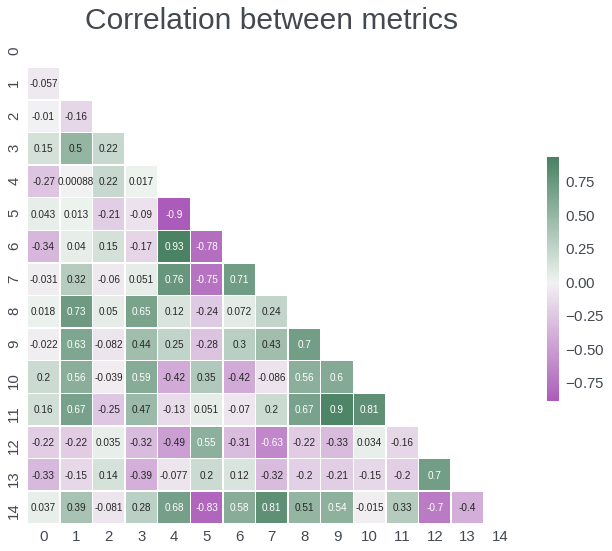

In [72]:
# plot empirical correlation of generated metrics
metric_corr = np.corrcoef(Y.numpy(), rowvar=False)

mask = np.triu(np.ones_like(metric_corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
# cmap = sns.diverging_palette(250, 20, as_cmap=True)
cmap = sns.diverging_palette(300, 145, s=60, as_cmap=True)

sns.heatmap(
    metric_corr,
    mask=mask,
    cmap=cmap,
    annot=True,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot_kws={"fontsize": 10},
)
plt.title("Correlation between metrics")

plt.savefig('A_exam_feed_integrity_control_panel_vm_tuning_heatmap.pdf')

Text(0.5, 1.0, 'PCA explained variance')

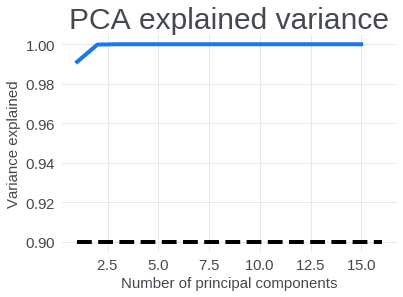

In [73]:
U, S, V = torch.svd(Y - torch.mean(Y, axis = 0))

plt.plot(list(range(1, 16)), torch.cumsum(torch.square(S) / torch.sum(torch.square(S)), dim=0))
plt.hlines(0.9, 1, 16, linestyles = '--')
plt.xlabel('Number of principal components')
plt.ylabel('Variance explained')
plt.title('PCA explained variance')

# Fit outcome model using different methods

In [86]:
pca_transform = PCAOutcomeTransform(variance_explained_threshold = 0.999)

pca_model = SingleTaskGP(
    X,
    Y,
    likelihood=GaussianLikelihood(
        noise_prior=GammaPrior(3, 6)
    ),  # TODO: GammaPrior(3,6) could be better for Ax experiments, QIng has a note
    input_transform=Normalize(3),
    outcome_transform=ChainedOutcomeTransform(
        **{"standardize": Standardize(Y.shape[-1], min_stdv = 100000), "pca": pca_transform}
    ),
)

# NOTE
# relativize -- sq also has variance, brings further noise into GP modeling
# absolute values -- just dealing with the observed standard errors of the arms

start = time.time()
pca_model_mll = ExactMarginalLogLikelihood(pca_model.likelihood, pca_model)
fit_gpytorch_scipy(pca_model_mll)
print(f"{time.time() - start} seconds")

num_axes = 2, explains 0.9998339199495703 variance


0.7516796588897705 seconds


In [87]:
st_model = SingleTaskGP(
    X,
    Y,
    likelihood=GaussianLikelihood(noise_prior=GammaPrior(3, 6)), # TODO: GammaPrior(3,6) could be better for Ax experiments, QIng has a note
    input_transform=Normalize(3),
    outcome_transform=Standardize(Y.shape[-1], min_stdv = 100000),
)

# NOTE
# relativize -- sq also has variance, brings further noise into GP modeling
# absolute values -- just dealing with the observed standard errors of the arms

start = time.time()
st_model_mll = ExactMarginalLogLikelihood(st_model.likelihood, st_model)
fit_gpytorch_scipy(st_model_mll)
print(f"{time.time() - start} seconds")

9.725991487503052 seconds


In [24]:
# MTGP with ICM kernel
# took more than 12 minutes
from botorch.models.multitask import KroneckerMultiTaskGP

icm_model = KroneckerMultiTaskGP(
    X,
    Y,
    outcome_transform=Standardize(Y.shape[-1], min_stdv = 1),
    rank=1,
)
icm_mll = ExactMarginalLogLikelihood(icm_model.likelihood, icm_model)

start = time.time()
icm_model_mll = ExactMarginalLogLikelihood(icm_model.likelihood, icm_model)
fit_gpytorch_scipy(icm_model_mll)
print(f"{time.time() - start} seconds")

KeyboardInterrupt: 

In [81]:
# MTGP with LMC kernel
from gpytorch.models import ExactGP
from torch import Tensor
from gpytorch.kernels import Kernel, LCMKernel, MaternKernel
import gpytorch

class MultitaskGPModel(GPyTorchModel, ExactGP):
    def __init__(
        self,
        train_X: Tensor,
        train_Y: Tensor,
        likelihood: Likelihood,
        num_tasks: int,
        multitask_kernel: Kernel,
        outcome_transform: OutcomeTransform = None,
        input_transform: InputTransform = None,
    ):

        r"""
        Initialize model class for multi-output GP models.

        Args:
            train_X: `num_samples x input_dim` tensor
            train_Y: `num_samples x outcome_dim` tensor
            likelihood: Gpytorch likelihood
            num_tasks: number of outcomes
            multitask_kernel: a multi-output kernel
            outcome_transform: OutcomeTransform
            input_transform: InputTransform

        """

        with torch.no_grad():
            transformed_X = self.transform_inputs(
                X=train_X, input_transform=input_transform
            )
        if outcome_transform is not None:
            train_Y, _ = outcome_transform(train_Y)
        self._validate_tensor_args(X=transformed_X, Y=train_Y)
        self._num_outputs = num_tasks

        super().__init__(
            train_inputs=train_X, train_targets=train_Y, likelihood=likelihood
        )

        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_tasks
        )
        self.covar_module = multitask_kernel

    def forward(self, x: Tensor):
        r"""
        Return posterior distribution at new point x
        """
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


def fit_LCM_model(
    train_X: Tensor,
    train_Y: Tensor,
    num_tasks: int,
    num_basis_kernels: int,
    rank: int = 1,
):
    r"""
    Fit LCM model with specified number of basis kernels and rank.
    Args:
        train_X: `num_samples x input_dim` tensor
        train_Y: `num_samples x outcome_dim` tensor
        num_tasks: number of outcomes
        num_basis_kernels: number of basis kernels in LCM kernel
        rank: rank of basis kernels, default to 1
    Returns:
        fitted model
    """
    lcm_kernel = LCMKernel(
        base_kernels=[MaternKernel()] * num_basis_kernels, num_tasks=num_tasks, rank=1
    )
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks)
    lcm_model = MultitaskGPModel(
        train_X, train_Y, likelihood, num_tasks=num_tasks, multitask_kernel=lcm_kernel
    )

    mll_lcm = ExactMarginalLogLikelihood(lcm_model.likelihood, lcm_model)
    fit_gpytorch_model(mll_lcm)

    return lcm_model


lcm_kernel = LCMKernel(
    base_kernels=[MaternKernel()],
    num_tasks=Y.shape[-1],
    rank=1,
)
lcm_likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
    num_tasks=Y.shape[-1]
)
lcm_model = MultitaskGPModel(
    X,
    Y,
    lcm_likelihood,
    num_tasks=Y.shape[-1],
    multitask_kernel=lcm_kernel,
    outcome_transform=Standardize(Y.shape[-1], min_stdv=1),
)
lcm_model.to(torch.double)
lcm_mll = ExactMarginalLogLikelihood(lcm_model.likelihood, lcm_model)

start = time.time()
lcm_model_mll = ExactMarginalLogLikelihood(lcm_model.likelihood, lcm_model)
fit_gpytorch_scipy(lcm_model_mll)
print(f"{time.time() - start} seconds")

115.4352285861969 seconds


In [88]:
lcm_model.state_dict()

OrderedDict([('likelihood.raw_task_noises',
              tensor([-15.1214, -14.3346, -16.5043, -16.4910,  -4.9332,  -3.2826,  -3.7722,
                      -18.6045, -19.7381, -18.4397, -14.9829, -15.8647, -15.1115, -15.0365,
                      -14.2762], dtype=torch.float64)),
             ('likelihood.raw_noise', tensor([-36.9617], dtype=torch.float64)),
             ('likelihood.raw_task_noises_constraint.lower_bound',
              tensor(1.0000e-04, dtype=torch.float64)),
             ('likelihood.raw_task_noises_constraint.upper_bound',
              tensor(inf, dtype=torch.float64)),
             ('likelihood.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04, dtype=torch.float64)),
             ('likelihood.raw_noise_constraint.upper_bound',
              tensor(inf, dtype=torch.float64)),
             ('mean_module.base_means.0.raw_constant',
              tensor(1.0977e-06, dtype=torch.float64)),
             ('mean_module.base_means.1.raw_constant',
    

# TODO: evaluate model fitting

In [67]:
# now check model fit, compute LOOCV
# have a loop, vary the number of principal axes kept, and compute LOOCV for each
# what is the relationship between explaining variance in the metrics vs having good model fit?
# this is what the plot is trying to get at

In [88]:
# loocv() function that takes model_class and input / output transforms as arguments


def loocv_new(
    X_all: torch.Tensor,
    Y_all: torch.Tensor,
    model_cls,  # TODO: add type = Model
    infer_noise: bool = True,
    Y_var_all: torch.Tensor or float = None,
    input_transform=None,  # TODO: add type
    outcome_transform=None,
    likelihood=None,
    **tkwargs
):

    print("Full input data shape {}, output data shape {}".format(X_all.shape, Y_all.shape))

    predicted_Y_means = torch.Tensor()
    predicted_Y_vars = torch.Tensor()

    explained_var = []
    num_axes = []

    for i in range(X_all.shape[0]):

        if i % 5 == 0:
            print("loocv round {}".format(i))

        X_train = torch.cat((X_all[:i], X_all[i + 1 :])).detach()
        Y_train = torch.cat((Y_all[:i], Y_all[i + 1 :])).detach()

        if Y_var_all is not None:
            if torch.is_tensor(Y_var_all):
                Y_var_train = torch.cat((Y_var_all[:i], Y_var_all[i + 1 :]))
            else:
                Y_var_train = Y_var_all
        else:
            Y_var_train = None

        X_test = X_all[i].unsqueeze(0)
        print(X_train.shape, Y_train.shape, X_test.shape)

                                        # TODO: PCA outcome transform only takes place once; self.training becomes False after first round. How to fix that?

        model = model_cls(
            X_train,
            Y_train,
                                                                                                                        # Yvar?
            likelihood=likelihood,
            input_transform=copy.deepcopy(input_transform),
            outcome_transform=copy.deepcopy(outcome_transform),
        )

        if 'pca' in model.outcome_transform:

            explained_var.append(model.outcome_transform["pca"].PCA_explained_variance)
            num_axes.append(model.outcome_transform["pca"].num_axes)

        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_model(mll)

        # print("model.posterior.event_shape", model.posterior(X_test).event_shape)

        Y_posterior_mean = model.posterior(X_test).mean
        Y_posterior_variance = model.posterior(X_test).variance

        # weird -- X_test is 1x3, posterior event shape is 1x15, but posterior mean shape is num_axes x 1 x 15

        # print("Y_posterior_mean.shape", Y_posterior_mean.shape)
        # print("predicted_Y_means.shape", predicted_Y_means.shape)

        # use loo-fitted model to compute the posterior mean on held-out datapoint
        predicted_Y_means = torch.cat((predicted_Y_means, Y_posterior_mean))
        predicted_Y_vars = torch.cat((predicted_Y_vars, Y_posterior_variance))

        # print("predicted_Y_means.shape afer torch.cat() new", predicted_Y_means.shape)

        # print(explained_var)
        del model

    # mean_explained_var = np.mean(explained_var)

    # print("predicted_Y_means.shape", predicted_Y_means.shape)

    return predicted_Y_means, predicted_Y_vars, explained_var, num_axes

In [89]:
loocv_outcome_mean, loocv_outcome_variance, explained_var, num_axes = loocv_new(
    X,
    Y,
    SingleTaskGP,
    input_transform=InputStandardize(3),
    outcome_transform=ChainedOutcomeTransform(
        **{"standardize": Standardize(Y.shape[-1], min_stdv=100000), "pca": PCAOutcomeTransform()}
    ),
    # likelihood=GaussianLikelihood(noise_prior=GammaPrior(0.9, 10)),
)

Full input data shape torch.Size([31, 3]), output data shape torch.Size([31, 15])
loocv round 0
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9907098129257047 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9911037806218304 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9912566040091274 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9911178106431776 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9914076328398865 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 5
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9901297655703366 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9899620194288086 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9931468524345713 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9909480904195321 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9931076243098138 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 10
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9912187408800959 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9916933165297313 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9903404175281139 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9907535870479977 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9912089584611258 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 15
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9901633394825647 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9913131715894591 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9910805801516805 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9912337133275989 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9914993003578246 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 20
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9913639137284819 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9911928771790817 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9905008629478707 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9911210371162095 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9899151564619358 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 25
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9906791652345659 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9914213521419656 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9912680225135205 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9911449219515085 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9911169228937485 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 30
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 1, explains 0.9911933187268865 variance


self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([1, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])


In [97]:
# PCA
mse_pca = torch.mean(torch.square(loocv_outcome_mean - Y), dim = 0)
print(mse_pca)

tensor([6.5022e-10, 1.1728e-04, 7.2367e-06, 7.8902e-07, 6.8729e+00, 1.5691e+00,
        3.4260e-02, 2.1566e-05, 4.2109e-04, 8.8598e-10, 1.9673e-09, 4.7682e-09,
        1.5507e-06, 2.4094e-06, 2.4444e-04], dtype=torch.float64,
       grad_fn=<MeanBackward1>)


In [98]:
# Indep
mse_indep = torch.mean(torch.square(loocv_outcome_mean_st - Y), dim = 0)
print(mse_indep)

tensor([6.6854e-10, 8.9802e-05, 7.2111e-06, 7.3455e-07, 3.1503e+01, 2.7789e+00,
        7.9485e-02, 3.5101e-05, 3.4196e-04, 8.3741e-10, 2.0275e-09, 4.2656e-09,
        1.7585e-06, 2.2265e-06, 6.8536e-05], dtype=torch.float64,
       grad_fn=<MeanBackward1>)


In [99]:
torch.mean(torch.square(loocv_outcome_mean - Y), dim = 0) < torch.mean(torch.square(loocv_outcome_mean_st - Y), dim = 0)

tensor([ True, False, False, False,  True,  True,  True,  True, False, False,
         True, False,  True, False, False])

In [100]:
mse_pca / mse_indep

tensor([0.9726, 1.3060, 1.0035, 1.0741, 0.2182, 0.5647, 0.4310, 0.6144, 1.2314,
        1.0580, 0.9703, 1.1178, 0.8818, 1.0821, 3.5665], dtype=torch.float64,
       grad_fn=<DivBackward0>)

In [50]:
torch.sum(torch.mean(torch.square(loocv_outcome_mean - Y), dim = 0)).item()

8.477056341416837

In [52]:
torch.sum(torch.sqrt(torch.mean(torch.square(loocv_outcome_mean - Y))), dim = 0).item()

0.7517560039186845

In [42]:
explained_var

[0.9158499456282487,
 0.91315337953457,
 0.9182127620450766,
 0.9169798904496302,
 0.9179392604460208,
 0.9146492232424648,
 0.9187640582040272,
 0.9157203868902666,
 0.9187682674017915,
 0.920712547592058,
 0.9243828771345184,
 0.9154005814896449,
 0.9133714025426254,
 0.92193309097677,
 0.9166385530771779,
 0.9150014384713844,
 0.9109195859990044,
 0.9243410555611314,
 0.9152023918650345,
 0.9200581722030551,
 0.9151951095175082,
 0.9145898960425456,
 0.9204339265915606,
 0.919995953130135,
 0.9138342606454363,
 0.9180942368520791,
 0.9192153728911955,
 0.9184799688071913,
 0.9180049825415025,
 0.9166000471655898,
 0.9170595873646257]

In [46]:
num_axes

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [91]:
loocv_outcome_mean_st, loocv_outcome_variance_st, mean_explained_var_st, _ = loocv_new(
    X,
    Y,
    SingleTaskGP,
    input_transform=InputStandardize(3),
    outcome_transform=ChainedOutcomeTransform(
        **{"standardize": Standardize(Y.shape[-1], min_stdv = 100000)}
    ),
    # likelihood=GaussianLikelihood(noise_prior=GammaPrior(0.9, 10)),
)

Full input data shape torch.Size([31, 3]), output data shape torch.Size([31, 15])
loocv round 0
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


loocv round 5
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


loocv round 10
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


loocv round 15
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


loocv round 20
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


loocv round 25
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


loocv round 30
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])


In [92]:
torch.mean(torch.square(loocv_outcome_mean_st - Y), dim = 0)

tensor([6.6854e-10, 8.9802e-05, 7.2111e-06, 7.3455e-07, 3.1503e+01, 2.7789e+00,
        7.9485e-02, 3.5101e-05, 3.4196e-04, 8.3741e-10, 2.0275e-09, 4.2656e-09,
        1.7585e-06, 2.2265e-06, 6.8536e-05], dtype=torch.float64,
       grad_fn=<MeanBackward1>)

In [49]:
torch.sum(torch.mean(torch.square(loocv_outcome_mean_st - Y), dim = 0)).item()


34.361849040600816

In [53]:
torch.sum(torch.sqrt(torch.mean(torch.square(loocv_outcome_mean_st - Y))), dim = 0).item()

1.513535574752062

In [54]:
torch.mean(torch.square(loocv_outcome_mean_st - Y))

tensor(0.4298, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [51]:
torch.mean(torch.square(loocv_outcome_mean_st - Y)).item()


0.42977626486503195

In [ ]:
# also otuput var explained for different number of axes kept?

In [48]:
MSE = []
explained_vars = []

for num_axes in range(2, Y.shape[-1]):

    print(f"PCA transform with {num_axes} principal axes")

    loocv_outcome_mean, loocv_outcome_variance, explained_var, _  = loocv_new(
        X,
        Y,
        SingleTaskGP,
        input_transform=InputStandardize(3),
        outcome_transform=ChainedOutcomeTransform(
            **{"standardize": Standardize(Y.shape[-1]), "pca": PCAOutcomeTransform(num_axes=num_axes)}
        ),
        likelihood=GaussianLikelihood(noise_prior=GammaPrior(3, 6), batch_shape=torch.Size([num_axes])), # TODO: change prior
    )

    print("loocv_outcome_mean.shape, Y.shape", loocv_outcome_mean.shape, Y.shape)
    print("torch.mean(torch.square(loocv_outcome_mean - Y))", torch.mean(torch.square(loocv_outcome_mean - Y)))

    MSE.append(torch.mean(torch.square(loocv_outcome_mean - Y)).item())

    mean_explained_var = np.mean(explained_var)
    explained_vars.append(mean_explained_var)

PCA transform with 2 principal axes
Full input data shape torch.Size([31, 3]), output data shape torch.Size([31, 15])
loocv round 0
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.6223068848578779 variance


self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.6191985867588905 variance
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.6256941757053145 variance


self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.6293256527324057 variance


self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.6292648228688607 variance


self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 5
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.6257260328152745 variance


self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.6248822665899069 variance


self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.6268885900055903 variance
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.6290390038806343 variance


self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.634757209202826 variance


self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 10
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.6330703139095091 variance


self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.6262559716725699 variance


self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.6224282458472185 variance
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.635111910286942 variance


self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.6299949856008984 variance
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 15
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.6386558438433277 variance


self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.601678686237831 variance
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.6379045137998502 variance


self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.6240095208194538 variance
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.6345245846676479 variance


self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 20
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.628422995650979 variance
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.6208296880595892 variance


self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.6432764577200026 variance
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.6346283635866894 variance


self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.6195144243574353 variance
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 25
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.6238318953013595 variance


self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.6436773422824966 variance
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.6330520837023146 variance


self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.6298943363681875 variance
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.629360956772073 variance


self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 30
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 2, explains 0.6373337635869889 variance
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([2, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv_outcome_mean.shape, Y.shape torch.Size([31, 15]) torch.Size([31, 15])


torch.mean(torch.square(loocv_outcome_mean - Y)) tensor(3.1610, dtype=torch.float64, grad_fn=<MeanBackward0>)
PCA transform with 3 principal axes
Full input data shape torch.Size([31, 3]), output data shape torch.Size([31, 15])
loocv round 0
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7424928548093062 variance


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7420744226742355 variance


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7450248830425981 variance


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7475103364650539 variance


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7475630221626339 variance


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 5
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7464046318729054 variance


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7453443914763995 variance


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7451606942622226 variance


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7481582056822771 variance


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7558432539523553 variance


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 10
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7526338461158026 variance


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7495722824457033 variance


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.741781443674784 variance
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7504598312700523 variance


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7472046862861519 variance


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 15
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7354763393000308 variance


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7272175281074843 variance


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7585566513670344 variance


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7418208264414835 variance


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7550171379331202 variance
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 20
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7416016166141985 variance


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.740838376080714 variance
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7578023110206188 variance


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7535760738064399 variance


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7420982120946833 variance
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 25
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7472095002675018 variance


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7474736930436563 variance


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7517003453191151 variance


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7479707749510679 variance


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7467858417458505 variance


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 30
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 3, explains 0.7514445047962293 variance


self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([3, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv_outcome_mean.shape, Y.shape torch.Size([31, 15]) torch.Size([31, 15])
torch.mean(torch.square(loocv_outcome_mean - Y)) tensor(3.0257, dtype=torch.float64, grad_fn=<MeanBackward0>)
PCA transform with 4 principal axes
Full input data shape torch.Size([31, 3]), output data shape torch.Size([31, 15])
loocv round 0
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.8304812791622971 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.8253977423565286 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.8328899791594206 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.8337871009283956 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.8336883466032978 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 5
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.828836060859758 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.8317677211909102 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.8322250801767282 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.833864869194786 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.8427625436280173 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 10
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.8403994974362411 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.8309036040603328 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.8271353688004073 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.8366656664822707 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.8340711984495957 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 15
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.8228065989901141 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.8190831847843099 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.8448128978766651 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.828358753277986 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.8406356595507131 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 20
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.829310615483853 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.8280923002480096 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.8445551295566529 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.8413411487178885 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.827404743449491 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 25
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.8345417727920627 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.8342419198664913 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.8370762677968056 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.8347992807635342 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.8324424672639055 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 30
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 4, explains 0.8343083240987752 variance


self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([4, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv_outcome_mean.shape, Y.shape torch.Size([31, 15]) torch.Size([31, 15])
torch.mean(torch.square(loocv_outcome_mean - Y)) tensor(2.9485, dtype=torch.float64, grad_fn=<MeanBackward0>)
PCA transform with 5 principal axes
Full input data shape torch.Size([31, 3]), output data shape torch.Size([31, 15])
loocv round 0
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.8816088700998342 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.87766266711813 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.8837418764355983 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.8844408320773518 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.8843043280815543 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 5
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.8803393350829479 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.8836761743680766 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.883224429961804 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.8848408040883149 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.888648600319794 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 10
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.8906580643627924 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.8836793512733202 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.8790741737972095 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.8873204296719464 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.8830506965703718 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 15
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.8791884368757712 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.8739868012458971 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.8908879191069398 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.8799911871430631 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.8855254253464779 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 20
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.8826552429978758 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.8797674797039495 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.8878697766625532 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.8925136810864583 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.8789614651523099 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 25
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.8849109812382394 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.886053274048231 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.8864574266299601 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.8827250308534774 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.8834342779412094 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 30
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 5, explains 0.8838562720795133 variance


self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([5, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv_outcome_mean.shape, Y.shape torch.Size([31, 15]) torch.Size([31, 15])
torch.mean(torch.square(loocv_outcome_mean - Y)) tensor(2.9463, dtype=torch.float64, grad_fn=<MeanBackward0>)
PCA transform with 6 principal axes
Full input data shape torch.Size([31, 3]), output data shape torch.Size([31, 15])
loocv round 0
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.9158499456282487 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.91315337953457 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.9182127620450766 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.9169798904496302 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.9179392604460208 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 5
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.9146492232424648 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.9187640582040272 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.9157203868902666 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.9187682674017915 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.920712547592058 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 10
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.9243828771345184 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.9154005814896449 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.9133714025426254 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.92193309097677 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.9166385530771779 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 15
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.9150014384713844 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.9109195859990044 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.9243410555611314 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.9152023918650345 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.9200581722030551 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 20
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.9151951095175082 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.9145898960425456 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.9204339265915606 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.919995953130135 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.9138342606454363 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 25
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.9180942368520791 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.9192153728911955 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.9184799688071913 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.9180049825415025 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.9166000471655898 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 30
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 6, explains 0.9170595873646257 variance


self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([6, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv_outcome_mean.shape, Y.shape torch.Size([31, 15]) torch.Size([31, 15])
torch.mean(torch.square(loocv_outcome_mean - Y)) tensor(2.9352, dtype=torch.float64, grad_fn=<MeanBackward0>)
PCA transform with 7 principal axes
Full input data shape torch.Size([31, 3]), output data shape torch.Size([31, 15])
loocv round 0
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9435893657488119 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.941372016030929 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9440047838659349 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9432856480363491 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9440087713105336 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 5
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9420359649725903 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9457904039574074 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9423367465048628 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9428734754436572 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9460232544425605 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 10
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9497858412445083 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9407483804110086 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9411352071505615 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9461032902587626 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9425275495227378 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 15
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9419745397000865 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9373764088283872 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9459086570238276 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9426849718788914 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9448593073124804 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 20
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9415598401554168 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9414861571897851 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9470084745788928 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.944045646668201 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9412691900511997 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 25
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9448358726373803 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9451554569190517 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9448266499380656 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9448825081262539 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9429016097370028 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 30
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 7, explains 0.9429882587989643 variance


self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([7, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv_outcome_mean.shape, Y.shape torch.Size([31, 15]) torch.Size([31, 15])
torch.mean(torch.square(loocv_outcome_mean - Y)) tensor(2.9253, dtype=torch.float64, grad_fn=<MeanBackward0>)
PCA transform with 8 principal axes
Full input data shape torch.Size([31, 3]), output data shape torch.Size([31, 15])
loocv round 0
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.9607550802903334 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.9591489405643532 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.960162858370811 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.9597693567456915 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.9610889430832463 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 5
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.9594565877877994 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.9630212103362635 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.9589739974426598 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.9603694530605841 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.9632012374605106 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 10
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.9649491210375686 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.9590625659638707 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.9594528225035848 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.9628679884116584 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.9597120485736506 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 15
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.9597200730070061 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.9572903512498468 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.9617238360044995 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.9606199588153225 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.9626250820662057 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 20
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.9590935053161999 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.9594603235116251 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.9626289628384574 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.9615811578402607 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.9590853607989916 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 25
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.96299466651209 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.9623193529923023 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.9619783909285247 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.963262725328545 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.9600780932262182 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 30
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 8, explains 0.960261210903546 variance


self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([8, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv_outcome_mean.shape, Y.shape torch.Size([31, 15]) torch.Size([31, 15])
torch.mean(torch.square(loocv_outcome_mean - Y)) tensor(2.8784, dtype=torch.float64, grad_fn=<MeanBackward0>)
PCA transform with 9 principal axes
Full input data shape torch.Size([31, 3]), output data shape torch.Size([31, 15])
loocv round 0
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9743221616381691 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9740191108116307 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9747718735869833 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9744146355528235 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9748619240256964 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 5
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9745026022329799 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9763543659423586 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9736022800840567 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9754276016110921 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9766845627755512 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 10
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9777040446033572 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9744981713203142 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9739073969245416 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9760118297269628 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9744027421601622 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 15
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9747939931572293 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9727995546103566 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9763805053968169 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9753167531125195 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9763704032601551 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 20
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9738015155000594 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9743431759862932 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9758875268971926 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9757605932176584 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9745552869864714 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 25
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9777113279938636 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9772388720990483 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.976592358134901 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9772750427403126 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9746631515891095 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 30
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 9, explains 0.9750824963994067 variance


self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([9, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv_outcome_mean.shape, Y.shape torch.Size([31, 15]) torch.Size([31, 15])
torch.mean(torch.square(loocv_outcome_mean - Y)) tensor(2.8681, dtype=torch.float64, grad_fn=<MeanBackward0>)
PCA transform with 10 principal axes
Full input data shape torch.Size([31, 3]), output data shape torch.Size([31, 15])
loocv round 0
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.9869777951569743 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.9867480422129953 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.9865487030695922 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.9869062867823568 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.9872891774985135 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 5
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.9870398295322661 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.9867919842517785 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.9866714415008079 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.987380669184762 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.9871538835443978 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 10
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.9869772933778614 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.9873859426030951 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.9862818644814884 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.987113555018308 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.9870439599557788 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 15
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.9872358362227348 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.9857153795906669 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.9883185426898441 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.98739008991622 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.9869825032762665 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 20
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.9868840121512623 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.9869379662322655 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.9870587331875045 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.9883439146516959 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.9877924740468885 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 25
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.9877258060029895 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.9870850770551242 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.9878988636216234 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.9871414841807684 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.9872455194213656 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 30
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 10, explains 0.987745706968149 variance


self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([10, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv_outcome_mean.shape, Y.shape torch.Size([31, 15]) torch.Size([31, 15])
torch.mean(torch.square(loocv_outcome_mean - Y)) tensor(2.8076, dtype=torch.float64, grad_fn=<MeanBackward0>)
PCA transform with 11 principal axes
Full input data shape torch.Size([31, 3]), output data shape torch.Size([31, 15])
loocv round 0
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9935690858348576 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9934546376356946 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9935981480283124 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9937202690317343 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9940544845688846 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 5
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9939330848969435 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9934845247078182 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9937321917688832 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9939647344074171 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9935802967443584 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 10
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9934466381302406 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9936761955591892 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9930582892148229 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9938375004436978 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9938450404065536 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 15
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9943201504689051 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9932445948161187 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9935521140410535 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9937482426669425 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9938682969612581 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 20
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9938038428518137 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9939107914517492 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9938477084401477 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9936459380452405 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9944012892588773 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 25
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9936119763071568 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9938606640945775 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9938023111207678 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9939125067604726 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9937672888964417 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 30
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 11, explains 0.9937777111463324 variance


self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([11, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv_outcome_mean.shape, Y.shape torch.Size([31, 15]) torch.Size([31, 15])
torch.mean(torch.square(loocv_outcome_mean - Y)) tensor(2.8088, dtype=torch.float64, grad_fn=<MeanBackward0>)
PCA transform with 12 principal axes
Full input data shape torch.Size([31, 3]), output data shape torch.Size([31, 15])
loocv round 0
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.9970263731206231 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.9969193287070861 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.9970233577640866 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.9971432100637734 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.9970533560973187 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 5
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.9970292792297664 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.9967644264453476 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.997159317231361 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.9972959804745816 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.9969749530308739 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 10
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.9969521233951969 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.9971848171390127 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.9967816765734703 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.9970197393802895 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.9972267677572617 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 15
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.9967545024552081 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.9969682402055065 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.9969955446492315 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.9972180073398234 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.9971274853428812 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 20
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.997020671040229 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.9973033987872068 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.996882293667058 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.9970259081402691 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.996898409713051 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 25
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.9971051112632477 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.9971986376624051 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.9971656913259833 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.9971464710336788 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.997145094548474 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 30
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 12, explains 0.9970778940692454 variance


self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([12, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv_outcome_mean.shape, Y.shape torch.Size([31, 15]) torch.Size([31, 15])
torch.mean(torch.square(loocv_outcome_mean - Y)) tensor(2.8113, dtype=torch.float64, grad_fn=<MeanBackward0>)
PCA transform with 13 principal axes
Full input data shape torch.Size([31, 3]), output data shape torch.Size([31, 15])
loocv round 0
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9986615473125688 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9986738537655983 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9987267407050657 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9987178208471446 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9987148615050565 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 5
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9988012505208164 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9986201321770655 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9990047280231625 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9988111161525882 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9987529651531823 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 10
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9987156756878321 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9989516426507958 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9986616624555767 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.998718471002873 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9987993704223505 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 15
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9986099894935314 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9985909385679574 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9987200962604618 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9987387590967175 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9988837242135671 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 20
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9987699924926872 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9987161542023274 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9986179217382254 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9987611300020404 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9987346345419642 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 25
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9987140045521906 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9988381241825156 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9988542153297735 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9987484203663504 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9987789578207057 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 30
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 13, explains 0.9987410075060572 variance


self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([13, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv_outcome_mean.shape, Y.shape torch.Size([31, 15]) torch.Size([31, 15])
torch.mean(torch.square(loocv_outcome_mean - Y)) tensor(2.8097, dtype=torch.float64, grad_fn=<MeanBackward0>)
PCA transform with 14 principal axes
Full input data shape torch.Size([31, 3]), output data shape torch.Size([31, 15])
loocv round 0
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.9996343994359845 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.9996066308002105 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.9996257414741674 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.9996180436437003 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.9996224853116797 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 5
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.9996671692944307 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.999627971073963 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.9996726165843305 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.9996248227502674 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.9996208269942163 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 10
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.9996194162445745 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.9997230256883324 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.9996598860658429 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.9996237909601237 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.9996597198613957 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 15
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.9996048485007059 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.9995572383558474 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.9996403154422348 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.9996244978771472 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.9997783216506922 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 20
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.9996211712843639 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.9996355590923307 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.999592217140854 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.9996231550544038 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.9996084150305619 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 25
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.9996506619837635 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.99965405398018 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.9996482476318079 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.9996249523937915 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.999665688184186 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv round 30
torch.Size([30, 3]) torch.Size([30, 15]) torch.Size([1, 3])
num_axes = 14, explains 0.9996008644848227 variance


self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
self.axes_learned.shape torch.Size([14, 15])
untransformed_posterior.rsample().shape torch.Size([1, 1, 15])
loocv_outcome_mean.shape, Y.shape torch.Size([31, 15]) torch.Size([31, 15])
torch.mean(torch.square(loocv_outcome_mean - Y)) tensor(2.7806, dtype=torch.float64, grad_fn=<MeanBackward0>)


([<matplotlib.axis.XTick at 0x7f741d3218e0>,
 <a list of 14 Text xticklabel objects>)

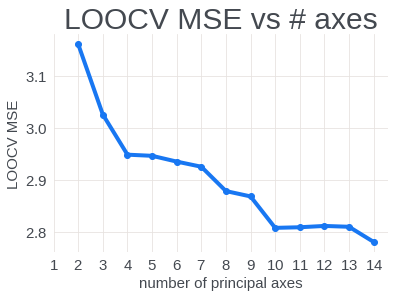

In [49]:
plt.plot(range(2, Y.shape[-1]), MSE, "-o")
plt.title("LOOCV MSE vs # axes")
plt.xlabel("number of principal axes")
plt.ylabel("LOOCV MSE")
plt.xticks(range(1, Y.shape[-1]))

# TODO: plot MSE per metric

In [38]:
explained_vars

[0.628856132564224,
 0.7468973715832808,
 0.8331834555808467,
 0.8837114616587409,
 0.9174032971710926,
 0.9435285241433904,
 0.9608617826765234,
 0.9752921890347764,
 0.987155236689882,
 0.9937429209260408,
 0.9970512279888242,
 0.9987467712499597,
 0.9996366694926102]

Text(0, 0.5, 'LOOCV MSE')

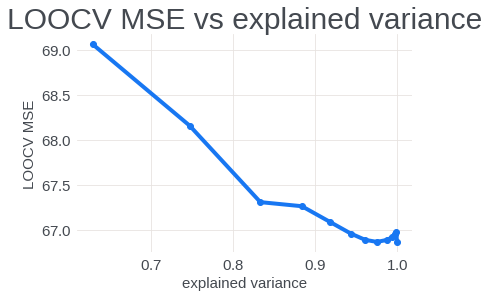

In [39]:
# can plot variance explained on the x-axis

plt.plot(explained_vars, MSE, "-o")
plt.title("LOOCV MSE vs explained variance")
plt.xlabel("explained variance")
plt.ylabel("LOOCV MSE")

In [ ]:
# on a bad day for PL with CI